**Table of contents**<a id='toc0_'></a>    
- 1. [Preface ](#toc1_)    
- 2. [Load datasets](#toc2_)    
  - 2.1. [Load earthquake catalog](#toc2_1_)    
  - 2.2. [Load PNSN tremor catalog (Wech)](#toc2_2_)    
    - 2.2.1. [(Pick the line on which events are projected, optional, can load)](#toc2_2_1_)    
  - 2.3. [Select earthquakes in the tremor region](#toc2_3_)    
  - 2.4. [Load tremoscope catalog](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface  [&#128285;](#toc0_)

In [8]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets [&#128285;](#toc0_)

In [3]:
# Constants for everyone
day0 = np.datetime64('2009-08-01')

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog [&#128285;](#toc0_)

In [75]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2009-08-01"
t1 = "2024-04-04"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 39
maxlat = 54
minlon = -128
maxlon = -121
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq['time'])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2009-08-01&endtime=2024-04-04&minlatitude=39&maxlatitude=54&minlongitude=-128&maxlongitude=-121&minmagnitude=1.6&eventtype=earthquake


## 2.2. <a id='toc2_2_'></a>Load PNSN tremor catalog (Wech) [&#128285;](#toc0_)

In [76]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/tremor_all_cascadia_09_24.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)
tremor['date'] = pd.to_datetime(tremor['starttime'])

# Find str in duration of tremor and convert them to float by stripping the space and converting to float (still misses some ' None ', don't know what to do with them...)
tremor.duration = tremor.duration.apply(lambda x: float(x.strip()) if x is str else x)

# Sort tremor by date
tremor = tremor.sort_values('date')

# Compute the day in the sequence for tremor
day0 = np.datetime64('2009-08-01')
tremor['day'] = (tremor.date - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_13324/3805188776.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


### 2.2.1. <a id='toc2_2_1_'></a>(Pick the line on which events are projected, optional, can load) [&#128285;](#toc0_)

In [77]:
# # Select points that define tremor region 
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# # Create an empty array to store the picked locations
# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lat, lon = event.ydata, event.xdata
#         picked_locations.append((lat, lon))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")

#         ax.plot([pl[1] for pl in picked_locations], [pl[0] for pl in picked_locations], 'ro-', transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

# # Add coastlines
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# # Add states
# ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# # Add tremor
# ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# # Set extent for Cascadia subduction zone
# extent = [-128, -121, 39, 52]
# ax.set_extent(extent)

In [78]:
# # Save picked locations
# plt.close()

# picked_locations = np.array(picked_locations)
# np.savetxt('data/cascadia/tremor_region_line.txt', picked_locations)

## 2.3. <a id='toc2_3_'></a>Select earthquakes in the tremor region [&#128285;](#toc0_)

In [79]:
# Project onto a straight line
# --> Define center line of tremor
lat_center = np.arange(39, 52, 0.2)
dlat = 0.4
center_line = np.zeros((len(lat_center), 2))

for ii, lat in enumerate(lat_center):
    lat_min = lat - dlat
    lat_max = lat + dlat
    tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
    center_line[ii, 1] = (lat_min + lat_max) / 2
    center_line[ii, 0] = tremor_bin.lon.median()

# --> Fit it with a straight line to find the transect points
p = np.polyfit(center_line[~np.isnan(center_line[:, 0]), 1], center_line[~np.isnan(center_line[:, 0]), 0], 1)
N_point = p[0] * 52 + p[1]
S_point = p[0] * 39 + p[1]
transect_line = {'N':{'lat': 52, 'lon': N_point}, 'S': {'lat': 39, 'lon': S_point}}

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1])
# plt.plot([transect_line['N']['lon'], transect_line['S']['lon']], [transect_line['N']['lat'], transect_line['S']['lat']])
# plt.show()

# --> Project earthquakes onto the line
t = transect(eq.lon.values, eq.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# --> Project tremor onto the line
t = transect(tremor.lon.values, tremor.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
tremor['xf'] = t[0]
tremor['yf'] = t[1]


In [80]:
# # To project onto more complex curve
# # for instance taking the median longitude of tremor for latitude bins
# # https://stackoverflow.com/questions/67490884/distance-between-a-point-and-a-curve-in-python
# # Even better, for better 

# # --> Define center line of tremor
# lat_center = np.arange(39, 52, 0.2)
# dlat = 0.4
# center_line = np.zeros((len(lat_center), 2))

# for ii, lat in enumerate(lat_center):
#     lat_min = lat - dlat
#     lat_max = lat + dlat
#     tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
#     center_line[ii, 1] = (lat_min + lat_max) / 2
#     center_line[ii, 0] = tremor_bin.lon.median()

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1], 'r--')
# plt.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5)
# plt.show()

# # --> Find the closest point on the line to each earthquake
# def distance(x, y, x0, y0):
#     "(x,y) line to consider, (x0, y0) sample point (event)"
#     d_x = x - x0
#     d_y = y - y0
#     dis = d_x**2 + d_y**2  # speeds it up to not take the sqrt
#     return dis


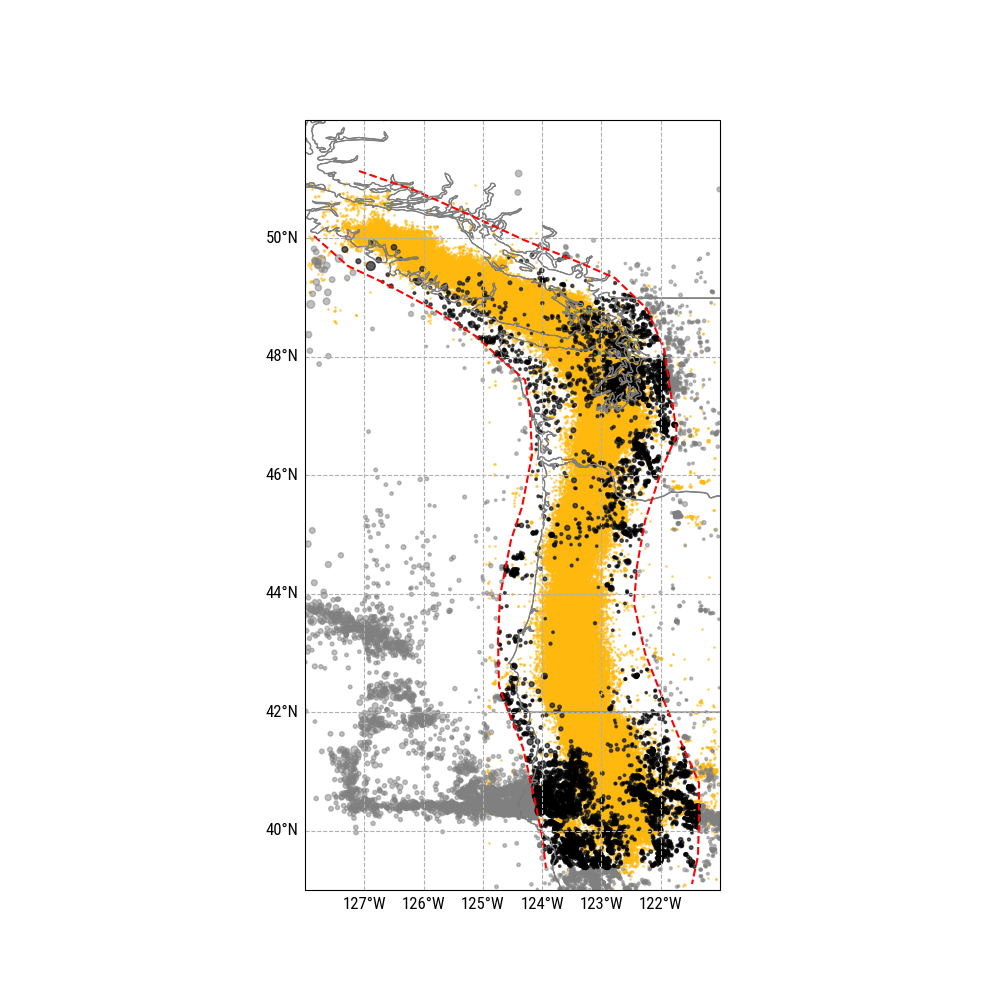

In [81]:
# Find which points are left or right of the line drawn on the map
east_line = np.loadtxt('data/cascadia/tremor_region_east_line.txt')
west_line = np.loadtxt('data/cascadia/tremor_region_west_line.txt')

# For each earthquake
def which_side(M, A, B):
    return np.sign((B[0] - A[0]) * (M[1] - A[1]) - (B[1] - A[1]) * (M[0] - A[0]))

# For each earthquake, find the points of the line it's longitude is between, and then using those points, find if the earthquake is left or right of the line
eq['east'] = np.zeros(len(eq))
eq['west'] = np.zeros(len(eq))
for ii, row in eq.iterrows():
    M = (row['lon'], row['lat'])
    for jj in range(len(east_line)-1):
        A = (east_line[jj][1], east_line[jj][0])
        B = (east_line[jj+1][1], east_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'east'] = side
    for jj in range(len(west_line)-1):
        A = (west_line[jj][1], west_line[jj][0])
        B = (west_line[jj+1][1], west_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'west'] = side

eq_near = eq[(eq.east == -1) & (eq.west == 1)]

%matplotlib widget
# Map of data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(eq_near.lon, eq_near.lat, s=eq_near.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Show east and west lines
ax.plot(east_line[:, 1], east_line[:, 0], 'r--', transform=ccrs.PlateCarree())
ax.plot(west_line[:, 1], west_line[:, 0], 'r--', transform=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

plt.show()

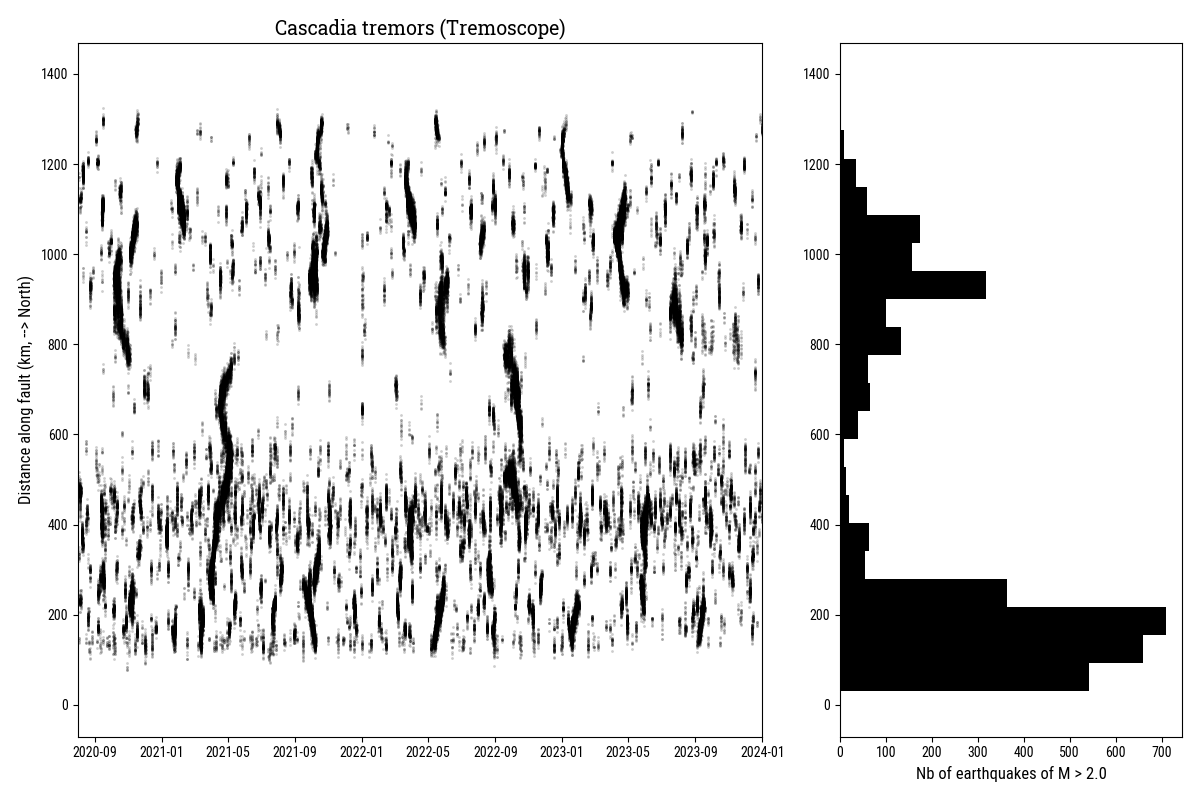

In [84]:
# Plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (Tremoscope)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(tremor.date, tremor.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax.set_xlim(np.datetime64('2020-08-01'), np.datetime64('2024-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[eq_near.mag > min_m], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

## 2.4. <a id='toc2_4_'></a>Load tremoscope catalog [&#128285;](#toc0_)

330924 tremor detections, spanning 2005--2014


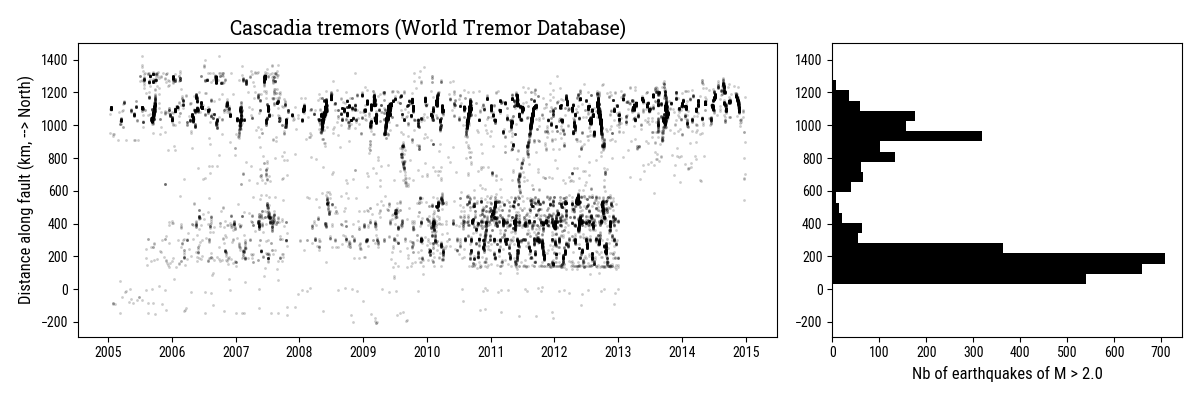

In [83]:
# World tremor database
path = workdir + 'projects/data/Catalogs/world_tremor_database/cascadia_wtb_0514.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd = pd.read_csv(
    path,
    names=COLS,
)

wtd['date_str'] = wtd.date.values + ' ' + wtd.time.values
wtd['date'] = pd.to_datetime(wtd.date_str)
day0 = np.datetime64('2005-01-01')
wtd['day'] = (wtd.date - day0) / np.timedelta64(1, 'D')

wtd.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd.size, wtd.date.min().year, wtd.date.max().year))

# Project tremors on the fault
t = transect(wtd.lon.values, wtd.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
wtd['xf'] = t[0]
wtd['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (World Tremor Database)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(wtd.date, wtd.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[(eq_near.mag > min_m)], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()